<a href="https://colab.research.google.com/github/LukasMut/AlignedReps/blob/plotting-notebooks/AlignedRepsPlotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Access the results folder

First, you have to go into the shared folder and add a shortcut to your own drive.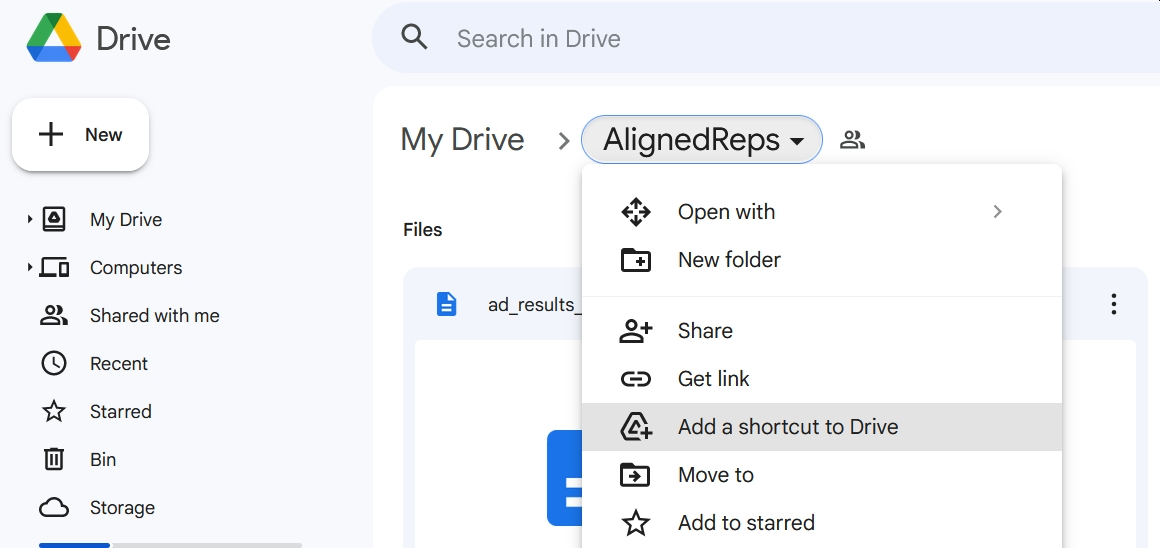

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
ROOT = "/content/drive/MyDrive/AlignedReps/AlignedReps"

Mounted at /content/drive/


In [ ]:
%load_ext autoreload
%autoreload 2
import os
import pickle
from itertools import product
import numpy as np
import pandas as pd
from typing import Any, List, Tuple
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
GLOCAL_GRID = {
    "optim":["sgd"], 
    "eta":[0.01, 0.001], 
    "lmbda":[10.0, 1.0, 0.1], 
    "alpha":[0.25, 0.1], 
    "tau":[1.0, 0.5], 
    "contrastive_batch_size":[1024]
}
GLOCAL_GRID_LARGE = {
    "optim":["sgd"], 
    "eta":[0.01, 0.001, 0.0001], 
    "lmbda":[10.0, 1.0, 0.1], 
    "alpha":[0.5, 0.25, 0.1], 
    "tau":[1.0, 0.5], 
    "contrastive_batch_size":[1024]
}
GLOBAL_GRID = {
    "optim":["adam"],#, None], # TODO change to adam 
    "eta":[0.0001, 1e-05], 
    "lmbda":[100.0, 10.0, 1.0, 0.1, 0.001, 0.0001], 
    "alpha":[None], 
    "tau":[None], 
    "contrastive_batch_size":[None]
}
MODEL2PRETTY = {
    "alexnet": "AlexNet", 
    "resnet18": "ResNet-18", 
    "resnet50": "ResNet-50",
    "vgg16": "VGG-16", 
    "clip_RN50": "CLIP-RN50", 
    "clip_ViT-L/14": "CLIP-ViT-L/14 (WIT)", 
    "OpenCLIP_ViT-L-14_laion400m_e32": "CLIP-ViT-L/14 (LAION-400M)", 
    "OpenCLIP_ViT-L-14_laion2b_s32b_b82k": "CLIP-ViT-L/14 (LAION-2B)" 
}
MODEL2SRC = {
    "alexnet": "torchvision", 
    "resnet18": "torchvision", 
    "resnet50": "torchvision",
    "vgg16": "torchvision", 
    "clip_RN50": "custom", 
    "clip_ViT-L/14": "custom", 
    "OpenCLIP_ViT-L-14_laion400m_e32": "custom", 
    "OpenCLIP_ViT-L-14_laion2b_s32b_b82k": "custom" 
}

def get_configs_data(data):
    params = ["optim", "eta", "lmbda", "alpha", "tau", "contrastive_batch_size"]
    cfgs = list(set([tuple([d[p] for p in params]) for _,d in data.iterrows()]))
    to_return = []
    for cfg in cfgs:
        sub_data = data
        for p in params:
            cfg_p = cfg[params.index(p)]
            if cfg_p is None or (type(cfg_p) != str and np.isnan(cfg_p)):
                sub_data = sub_data[sub_data[p].isna()]
            else:
                sub_data = sub_data[sub_data[p] == cfg_p]
        if len(sub_data)>0:
            to_return.append(sub_data)
    return to_return

def get_fs_data(glocal=True):
    fs_results = pd.read_pickle(os.path.join(ROOT, f"fs_results_glo{'c' if glocal else 'b'}al.pkl"))
    tasks_fs = [i for i in fs_results["dataset"].unique()]
    datas_fs = []
    for fs_task in tasks_fs:
        datas_fs.append(fs_results[fs_results["dataset"] == fs_task])       
    return datas_fs, tasks_fs

def get_ad_data(glocal=True):
    ad_results = pd.read_csv(os.path.join(ROOT, f"ad_results_v1.csv"))
    if glocal:
      ad_results = ad_results[ad_results.transform_type == 'glocal']
    else:
      ad_results = ad_results[ad_results.transform_type == 'global']
       
    tasks_ad = [i for i in ad_results["dataset"].unique()]
    ad_models = [i for i in ad_results["model"].unique()]
    if glocal:
      ad_results["eta"] = ad_results["transform"].str.split('/').str[-6]
      ad_results["lmbda"] = ad_results["transform"].str.split('/').str[-5]
      ad_results["alpha"] = ad_results["transform"].str.split('/').str[-4]
      ad_results["tau"] = ad_results["transform"].str.split('/').str[-3]
      ad_results["contrastive_batch_size"] = ad_results["transform"].str.split('/').str[-2]
    else:
      ad_results["eta"] = ad_results["transform"].str.split('/').str[-2]
      ad_results["lmbda"] = ad_results["transform"].str.split('/').str[-4]
      ad_results["alpha"] = None
      ad_results["tau"] = None
      ad_results["contrastive_batch_size"] = None
    ad_results['model'] = ad_results['model'].replace('clip_ViT-L-14', 'clip_ViT-L/14')
    ad_results['model_pretty'] = ad_results['model'].replace(MODEL2PRETTY)
    
    ad_results["ad_auc_t"] = ad_results["mean_auc"].astype(float)
    for column in ['eta', 'lmbda', 'tau', 'contrastive_batch_size', 'alpha']:
      ad_results[column] = ad_results[column].astype(float)

    # Filter to grid
    # TODO: filter to larger grid for imagenet models
    ad_results = ad_results[((ad_results.eta.isin(GLOBAL_GRID["eta"])) & (ad_results.lmbda.isin(GLOBAL_GRID["lmbda"])) & (ad_results.tau.isna())) | ((ad_results.eta.isin(GLOCAL_GRID["eta"])) & (ad_results.lmbda.isin(GLOCAL_GRID["lmbda"])) & (ad_results.tau.isin(GLOCAL_GRID["tau"])) & (ad_results.contrastive_batch_size.isin(GLOCAL_GRID["contrastive_batch_size"])) & (ad_results.alpha.isin(GLOCAL_GRID["alpha"])))]
    datas_ad = []
    for ad_task in tasks_ad:
        datas_ad.append(ad_results[ad_results["dataset"] == ad_task])   
    return datas_ad, tasks_ad

# **Data Loading**



In [ ]:
models = [k for k in MODEL2PRETTY.keys()]
srcs = [MODEL2SRC[m] for m in models]
module="penultimate"

print("### Loading FS data")
# Load all FS data
datas_fs, tasks_fs = get_fs_data()
datas_global_fs, _, = get_fs_data(glocal=False)
# Filter coarse/fine
task_fs_is_super = [("entity" in t) or ("coarse" in t) for t in tasks_fs]
datas_fs_c = [data[data.samples_per_superclass==sps] for data, sps in zip(datas_fs, task_fs_is_super) if sps]
datas_global_fs_c = [data[data.samples_per_superclass==sps] for data, sps in zip(datas_global_fs, task_fs_is_super) if sps]
datas_fs_f = [data[data.samples_per_superclass==sps] for data, sps in zip(datas_fs, task_fs_is_super) if not sps]
datas_global_fs_f = [data[data.samples_per_superclass==sps] for data, sps in zip(datas_global_fs, task_fs_is_super) if not sps]
datas_fs_cf = datas_fs_c + datas_fs_f
datas_global_fs_cf = datas_global_fs_c + datas_global_fs_f

print("### Loading AD data")
datas_ad, tasks_ad = get_ad_data()
datas_global_ad, _ = get_ad_data(glocal=False)

### Loading FS data
### Loading AD data


In [ ]:
for t,d,dg in zip(tasks_ad, datas_ad, datas_global_ad):
  print(f"Length for {t}(AD): glocal={len(d)} \tglobal={len(dg)}")
print()
for t,d,dg in zip(tasks_fs, datas_fs, datas_global_fs):
  print(f"Length for {t}(FS): glocal={len(d)} \tglobal={len(dg)}")

Length for cifar10(AD): glocal=113 	global=116
Length for cifar100(AD): glocal=113 	global=116
Length for cifar100-coarse(AD): glocal=113 	global=116
Length for cifar100-shift(AD): glocal=113 	global=116

Length for entity13(FS): glocal=2040 	global=336
Length for entity30(FS): glocal=2052 	global=330
Length for cifar100(FS): glocal=774 	global=72
Length for cifar100-coarse(FS): glocal=1548 	global=228
Length for SUN397(FS): glocal=336 	global=36
Length for DTD(FS): glocal=1032 	global=156


In [ ]:
datas_ad[0].head()

,dataset,model,transform,mean_auc,eta,lmbda,alpha,tau,contrastive_batch_size,model_pretty,ad_auc_t
18,cifar10,clip_ViT-L/14,/home/space/datasets/things/probing/results/cu...,0.971153,0.001,10.0,0.10,1.0,1024.0,CLIP-ViT-L/14 (WIT),0.971153
20,cifar10,clip_ViT-L/14,/home/space/datasets/things/probing/results/cu...,0.971124,0.001,10.0,0.10,0.5,1024.0,CLIP-ViT-L/14 (WIT),0.971124
30,cifar10,clip_ViT-L/14,/home/space/datasets/things/probing/results/cu...,0.970171,0.001,10.0,0.25,1.0,1024.0,CLIP-ViT-L/14 (WIT),0.970171
32,cifar10,clip_ViT-L/14,/home/space/datasets/things/probing/results/cu...,0.970095,0.001,10.0,0.25,0.5,1024.0,CLIP-ViT-L/14 (WIT),0.970095
39,cifar10,clip_ViT-L/14,/home/space/datasets/things/probing/results/cu...,0.981596,0.001,0.1,0.10,1.0,1024.0,CLIP-ViT-L/14 (WIT),0.981596


In [ ]:
datas_fs[0].head()

,model,module,source,family,dataset,transform,n_train,regressor,samples_per_superclass,optim,...,lmbda,alpha,tau,contrastive_batch_size,glocal,model_pretty,fs_accuracy_t,fs_accuracy_diff_mean,fs_accuracy_diff_std,fs_accuracy
0,clip_RN50,penultimate,custom,CLIP,entity13,False,2,ridge,False,sgd,...,0.1,0.25,0.5,1024.0,True,CLIP-RN50,0.732615,NaN,NaN,0.715877
1,clip_RN50,penultimate,custom,CLIP,entity13,False,2,ridge,False,sgd,...,0.1,0.1,1.0,1024.0,True,CLIP-RN50,0.740523,NaN,NaN,0.715877
2,clip_RN50,penultimate,custom,CLIP,entity13,False,2,ridge,False,sgd,...,10.0,0.1,1.0,1024.0,True,CLIP-RN50,0.721192,NaN,NaN,0.719904
3,clip_RN50,penultimate,custom,CLIP,entity13,False,2,ridge,False,sgd,...,1.0,0.25,1.0,1024.0,True,CLIP-RN50,0.730215,NaN,NaN,0.715877
4,clip_RN50,penultimate,custom,CLIP,entity13,False,2,ridge,False,sgd,...,10.0,0.1,0.5,1024.0,True,CLIP-RN50,0.723442,NaN,NaN,0.719192


# **Plotting**

In [ ]:
# Here we can set style settings, palettes, ...
sns.set_style("white")
sns.set_context("paper")
PALETTE_MODELS = "deep"
PALETTE_HEAT = "flare"

In [ ]:
def plot_fs(data_avg, task):
    # Plots a large grid of FS results over all datasets and shots
    shots = list(set(data_avg.n_train))
    regressors = list(set(data_avg.regressor))
    models = list(set(data_avg.model))
    spss=list(set(data_avg.samples_per_superclass))
    n_s = len(shots)
    n_r = len(regressors)

    for sps in spss:
        fig, axs = plt.subplots(n_r,n_s,figsize=(4*n_s, 4*n_r))
        if n_s==1:
            axs = np.array([axs])
        if n_r==1:
            axs = np.array([[ax] for ax in axs])
        for s_i,s in enumerate(shots):
            for r_i, r in enumerate(regressors):
                data_avgc = data_avg[(data_avg["regressor"]==r) & (data_avg["n_train"]==s) & (data_avg["samples_per_superclass"]==sps)]
                minv = min(np.min(data_avgc["fs_accuracy"]), np.min(data_avgc["fs_accuracy_t"]))
                maxv = max(np.max(data_avgc["fs_accuracy"]), np.max(data_avgc["fs_accuracy_t"]))
                sns.scatterplot(data_avgc, 
                            x="fs_accuracy",
                            y="fs_accuracy_t",
                            hue="model_pretty", 
                            ax=axs[s_i, r_i],
                            palette=PALETTE_MODELS)
                minv-=0.025
                maxv+=0.025
                axs[s_i, r_i].set_title(f"{task}\n" + f" {s}-shot (per-super={sps}) {r}")
                axs[s_i, r_i].set_xlim([minv, maxv])
                axs[s_i, r_i].set_xlabel("Accuracy")
                axs[s_i, r_i].set_ylim([minv, maxv])
                axs[s_i, r_i].set_ylabel("Transformed Accuracy")
                axs[s_i, r_i].plot(axs[s_i, r_i].get_xlim(), 
                                   axs[s_i, r_i].get_ylim(), 
                                   "--", alpha=0.8, color="grey", zorder=0)

                if s_i == len(shots) - 1:
                    axs[s_i, r_i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')    
                else:
                    axs[s_i, r_i].get_legend().remove()
        plt.tight_layout()
        plt.show()

def plot_adfs(datas_ad, datas_fs, n_shots=2, regressor="ridge", sps=False, models=None):
    # Plots a scatter plot: AD vs FS performance
    n = len(datas_ad)
    m = len(datas_fs)
    palette = plt.colormaps['viridis']

    fig, axs = plt.subplots(n,m,figsize=(4*m, 3*n))
    if n==1:
        axs = np.array([axs])
    if m==1:
        axs = np.array([[ax] for ax in axs])

    models = models if models is not None else datas_fs[0].model.unique()

    tasks_ad = list([set(data.dataset).pop() for data in datas_ad])
    tasks_fs = list([set(data.dataset).pop() for data in datas_fs])    

    for i_ad, (ad_data, ad_task) in enumerate(zip(datas_ad, tasks_ad)):
        for i_fs, (fs_data, fs_task) in enumerate(zip(datas_fs, tasks_fs)):
            fs_data = fs_data[(fs_data["regressor"]==regressor) & (fs_data["n_train"]==n_shots) & (fs_data["samples_per_superclass"]==sps)]

            for m_i, model in enumerate(models):
                color = palette(m_i / (len(models)))
                x_data = fs_data[fs_data["model"]==model].copy()
                y_data = ad_data[ad_data["model"]==model].copy()
                joint = x_data.merge(y_data, on=['eta', 'lmbda', 'tau', 'contrastive_batch_size', 'alpha'], how='inner')
                x = joint["fs_accuracy_t"]
                y = joint["ad_auc_t"]

                if len(x) == 0:
                    print("No joint data..")
                    continue
                #print(len(joint), "joint data points")
                # TODO: make seaborn
                axs[i_ad, i_fs].scatter(x, y, color=[color]*len(x), label=MODEL2PRETTY[model])
                if i_ad == len(tasks_ad)-1:
                    axs[i_ad, i_fs].set_xlabel(f"FS Acc {fs_task}" + (" (sps)" if sps else ""))
                if i_fs == 0:
                    axs[i_ad, i_fs].set_ylabel(f"AD AUC {ad_task}")

                axs[i_ad, i_fs].legend()        
    plt.tight_layout()
    plt.show()
    
def plot_adfs_corr(datas_ad, datas_fs, n_shots=2, regressor="ridge", sps=False, models=None):
    # Plots a correlation matrix: AD vs FS over transforms
    n = len(datas_ad)
    m = len(datas_fs)

    models = models if models is not None else datas_fs[0].model.unique()
    tasks_ad = list([set(data.dataset).pop() for data in datas_ad])
    tasks_fs = list([set(data.dataset).pop() for data in datas_fs])

    for m_i, model in enumerate(models):
        corrs = np.zeros([n,m])
        for i_ad, (ad_data, ad_task) in enumerate(zip(datas_ad, tasks_ad)):
            for i_fs, (fs_data, fs_task) in enumerate(zip(datas_fs, tasks_fs)):
                fs_data = fs_data[(fs_data["regressor"]==regressor) & (fs_data["n_train"]==n_shots) & (fs_data["samples_per_superclass"]==sps)]
                x_data = fs_data[fs_data["model"]==model].copy()
                y_data = ad_data[ad_data["model"]==model].copy()
                joint = x_data.merge(y_data, on=['eta', 'lmbda', 'tau', 'contrastive_batch_size', 'alpha'], how='inner')
                corrs[i_ad, i_fs] = np.corrcoef(joint["fs_accuracy_t"], joint["ad_auc_t"])[0,1]

        sns.heatmap(
                data=corrs,
                annot=True,
                #cbar=True, #True if cbar else False,
                square=True,
                xticklabels=True, #'auto',
                yticklabels=True, #'auto',
                alpha=.8,
                cmap=sns.color_palette(PALETTE_HEAT, as_cmap=True),
        )
        plt.xlabel('')
        axis = plt.gca()
        axis.set_yticks(0.5 + np.arange(len(tasks_ad)))
        axis.set_yticklabels(tasks_ad, rotation=40, ha="right", rotation_mode="anchor")
        axis.set_xticks(0.5 + np.arange(len(tasks_fs)))
        axis.set_xticklabels(tasks_fs, rotation=40, ha="right", rotation_mode="anchor")
        plt.tight_layout()
        plt.title("Task correlations for %s" %model)
        plt.show()
    
def plot_fs_glob(datas, datas_glob, tasks, n_shots=2, regressor="ridge", sps=False, models=None):
    # Plots boxplot for FS global vs glocal
    n = len(datas)
    m = 1#len(datas_glob)
    models = models if models is not None else datas_fs[0].model.unique()

    fig, axs = plt.subplots(n,m,figsize=(4*m, 3*n))
    if n==1:
        axs = np.array([axs])
    if m==1:
        axs = np.array([[ax] for ax in axs])
        
    for i1, (data, task1) in enumerate(zip(datas, tasks)):
        i2=0
        data_glob=datas_glob[i1]
        task2=task1
        datac = data[(data["regressor"]==regressor) & (data["n_train"]==n_shots) & (data["samples_per_superclass"]==sps)].copy()
        data_globc = data_glob[(data_glob["regressor"]==regressor) & (data_glob["n_train"]==n_shots) & (data_glob["samples_per_superclass"]==sps)].copy()
        for column in ['eta', 'lmbda', 'tau', 'contrastive_batch_size', 'alpha']:
                data_globc[column] = data_globc[column].astype(float)
        joint = pd.concat([datac,data_globc])
        
        sns.boxplot(data=joint, 
                    y="fs_accuracy_t", 
                    x="model_pretty", 
                    hue="glocal", 
                    ax=axs[i1, i2],
                    palette=PALETTE_MODELS)

        dataset1 = datac["dataset"].unique()[0]
        dataset2 = data_globc["dataset"].unique()[0]
        
        axs[i1, i2].set_xlabel("Model")

        if i2 == 0:
            axs[i1, i2].set_ylabel(task2 + (" (sps)" if sps else ""))
        else:
            axs[i1, i2].set_ylabel(None)
        print(models)
        axs[i1, i2].set_xticklabels(models, rotation=40, ha="right", rotation_mode="anchor")

    plt.legend()        
    plt.tight_layout()
    plt.show()

def select_by(data, selector_data, selector_col):
    models = selector_data.model.unique()
    selector_data = selector_data.copy()
    selector_data["selector_col"] = selector_data[selector_col]
    selector_data["selector_dataset"] = selector_data["dataset"]
    selector_data = selector_data[["selector_col", "selector_dataset", 'eta', 'lmbda', 'tau', 'contrastive_batch_size', 'alpha', "model"]]
    merged = selector_data.merge(data, on=['eta', 'lmbda', 'tau', 'contrastive_batch_size', 'alpha', "model"], how='inner')
    
    best_all_models = []
    for m_i, model in enumerate(models):
        if "repetition" in data.columns:
            best = []
            if "n_train" in data.columns:
                for r in data.repetition.unique():
                    for n in data.n_train.unique():
                        best = merged[(merged.model == model) & (merged.repetition == r) & (merged.n_train == n)].nlargest(1, "selector_col")
                        best_all_models.append(best)
            else:
                for r in data.repetition.unique():
                    best = merged[(merged.model == model) & (merged.repetition == r)].nlargest(1, "selector_col")
                    best_all_models.append(best)
        elif "n_train" in data.columns:
            best = []
            for n in data.n_train.unique():
                best = merged[(merged.model == model) & (merged.n_train == n)].nlargest(1, "selector_col")
                best_all_models.append(best)
        else:
            best = merged[merged.model == model].nlargest(1, "selector_col")
            best_all_models.append(best)
    best_all_models = pd.concat(best_all_models)
    return best_all_models

def task_selection_adfs(datas_ad, data_avgs_fs, sps=False, n_shots=4, models=["clip_ViT-L/14"]):
    n = len(datas_ad)
    m = len(datas_fs)

    models = models if models is not None else datas_fs[0].model.unique()
    tasks_ad = list([set(data.dataset).pop() for data in datas_ad])
    tasks_fs = list([set(data.dataset).pop() for data in datas_fs])
    
    for m_i, model in enumerate(models):
        selector_value = np.zeros([m+n,m+n])
        for i_dat, (data1, task1) in enumerate(zip(datas_ad + data_avgs_fs, tasks_ad + tasks_fs)):
            data1 = data1[data1.model == model]
            if i_dat >= n:
                #fs seletor task
                selector_col = "fs_accuracy_t"
                data1 = data1[(data1["n_train"]==n_shots)]
                if sps is not None:
                    data1 = data1[data1["samples_per_superclass"]==sps]
            else:
                # ad selector task
                selector_col = "ad_auc_t"
            for j_dat, (data2, task2) in enumerate(zip(datas_ad + data_avgs_fs, tasks_ad + tasks_fs)):
                data2 = data2[data2.model == model]
                if j_dat >= n:
                    #fs seleted task
                    selected_col = "fs_accuracy_t"
                    data2 = data2[data2["n_train"]==n_shots]
                    if sps is not None:
                        data2 = data2[data2["samples_per_superclass"]==sps]
                else:
                    # ad selected task
                    selected_col = "ad_auc_t"
                data2 = data2.copy()
                data2["selected"] = data2[selected_col]
                try:
                    selected = select_by(data2, data1, selector_col)
                except ValueError:
                    #print("No intersecting hyperparams found:", model, task1, task2)
                    selector_value[i_dat, j_dat] = 0
                    continue

                try:
                    selector_value[i_dat, j_dat] = float(selected["selected"])
                    # print("   Selected", task2, selected_col,  selected["selected"])
                except:
                    selector_value[i_dat, j_dat] = 0
        
        fig, ax = plt.subplots(figsize=(8,8))
        sns.heatmap(
                data=selector_value,
                annot=True,
                square=True,
                xticklabels=True,
                yticklabels=True,
                alpha=.8,
                cmap=sns.color_palette(PALETTE_HEAT, as_cmap=True),
                ax=ax
        )
        plt.xlabel('')
        axis = plt.gca()
        axis.set_ylabel("Selector")
        axis.set_yticks(0.5 + np.arange(n+m))
        axis.set_yticklabels(tasks_ad + tasks_fs, rotation=40, ha="right", rotation_mode="anchor")
        axis.set_xlabel("Selected")
        axis.set_xticks(0.5 + np.arange(n+m))
        axis.set_xticklabels(tasks_ad + tasks_fs, rotation=40, ha="right", rotation_mode="anchor")
        plt.tight_layout()
        plt.title("Task peformance for %s" % MODEL2PRETTY[model])
        plt.show()

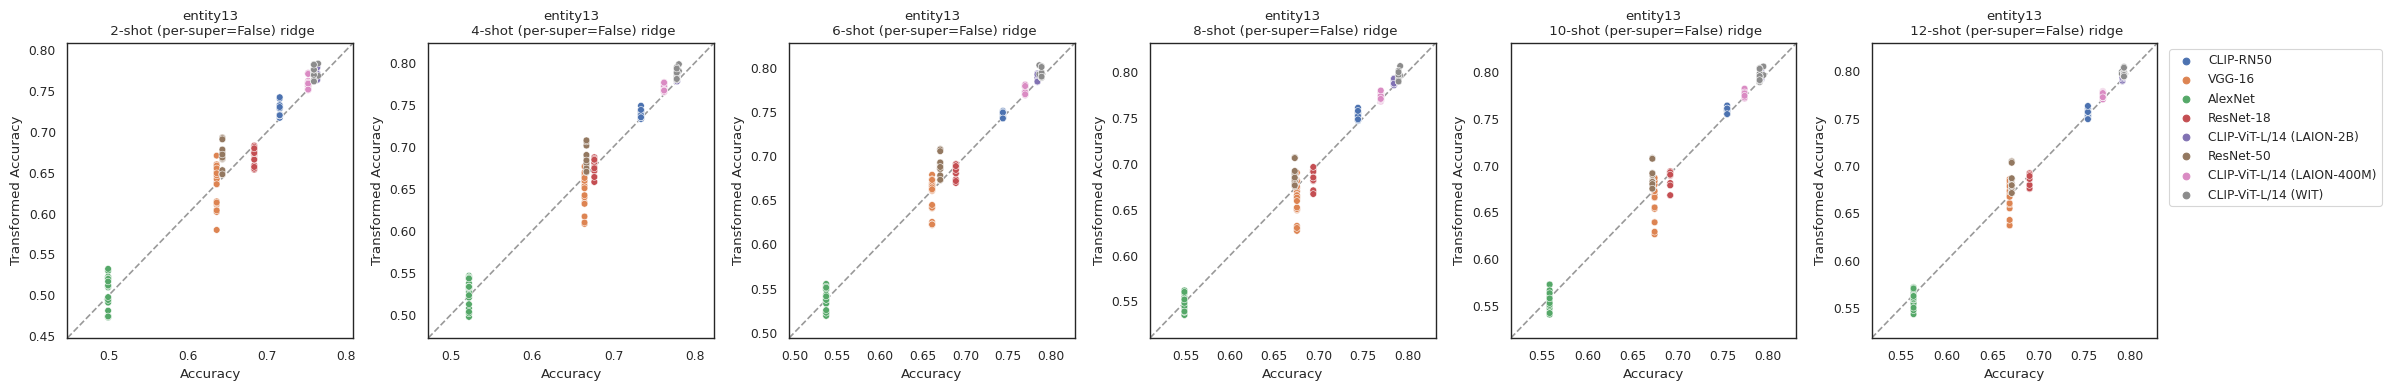

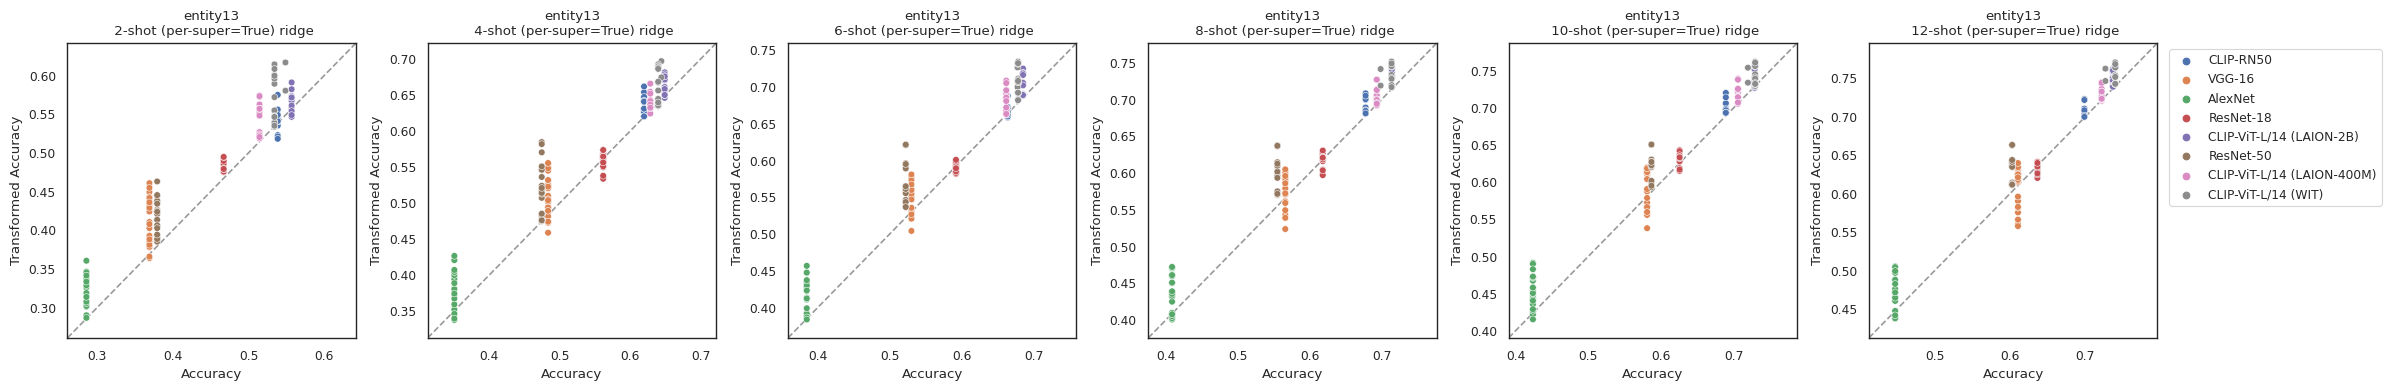

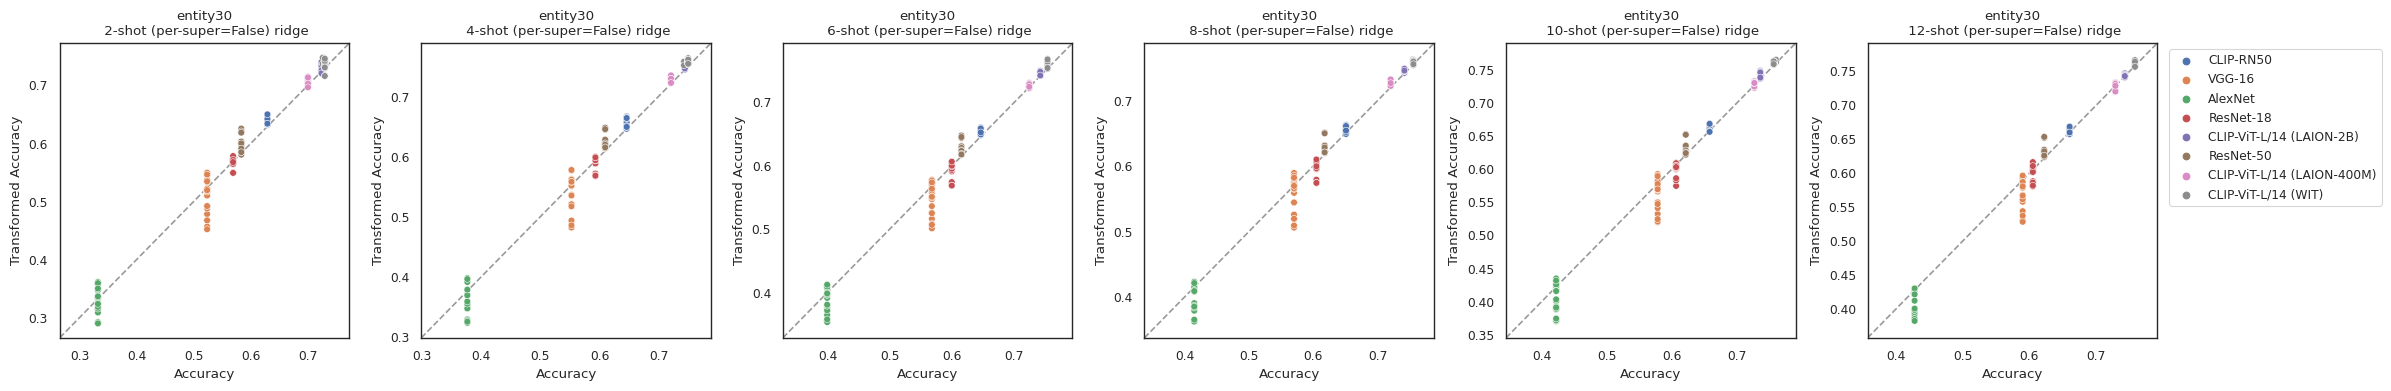

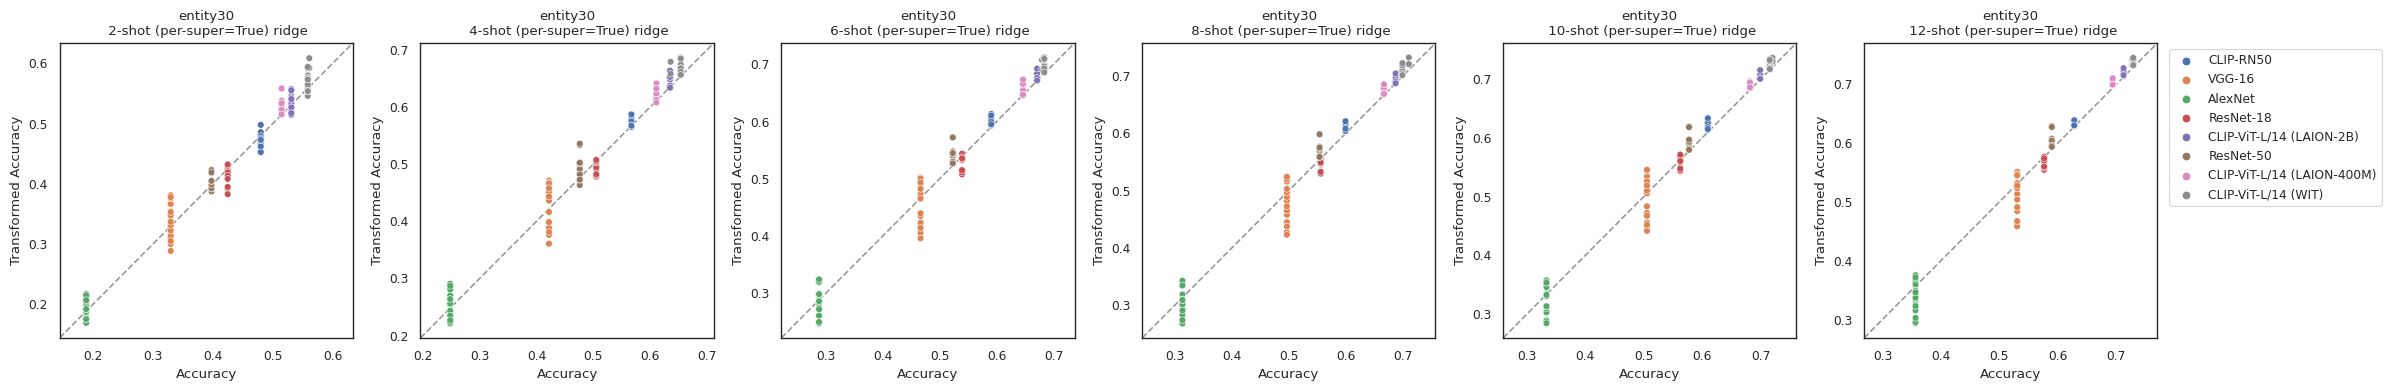

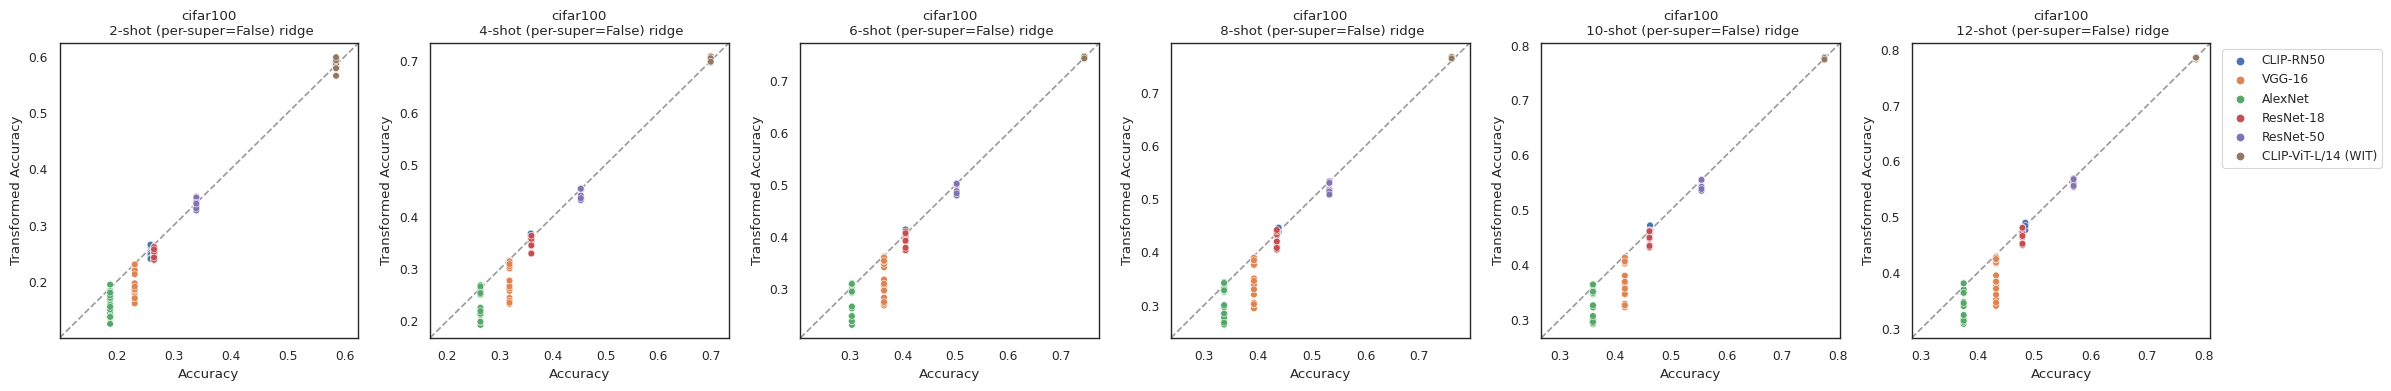

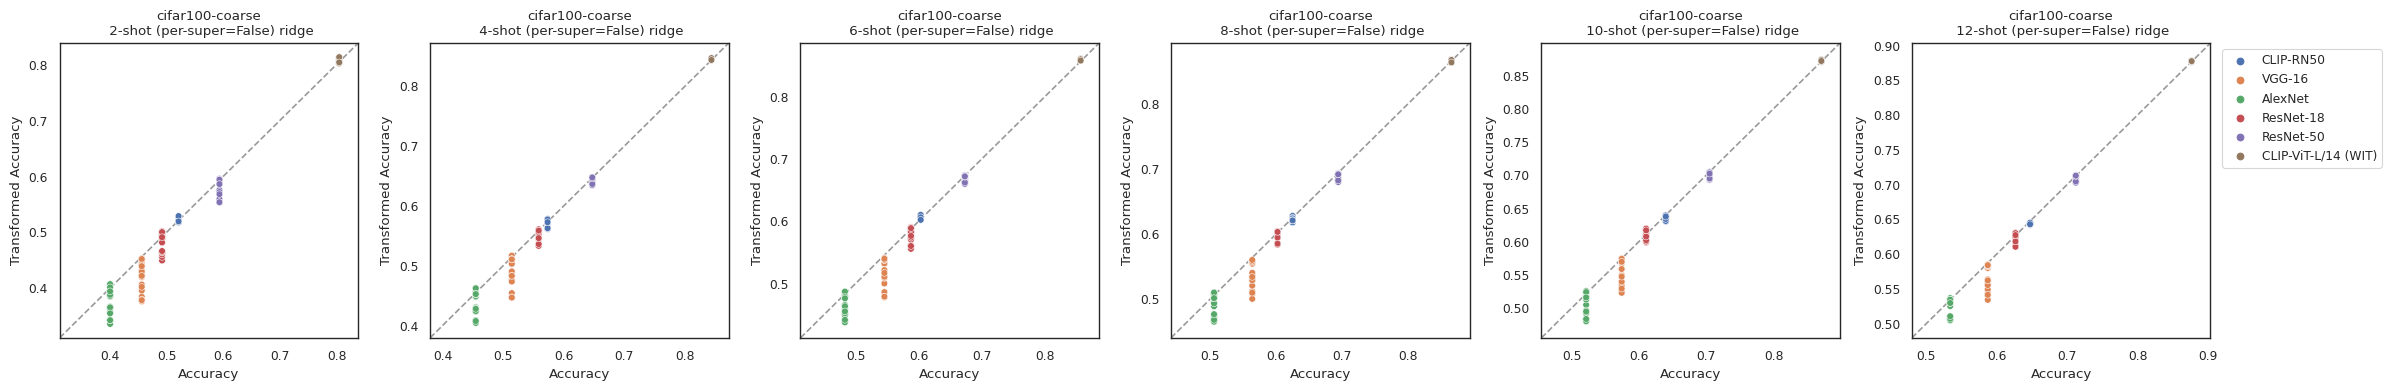

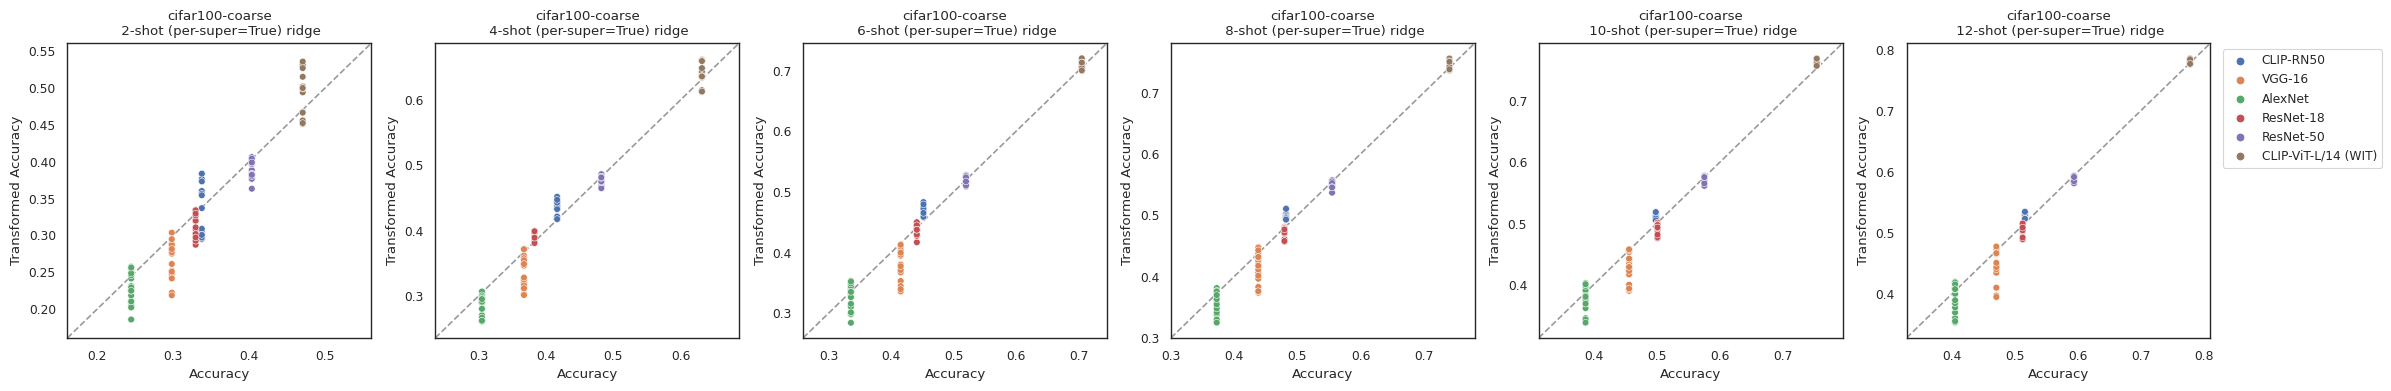

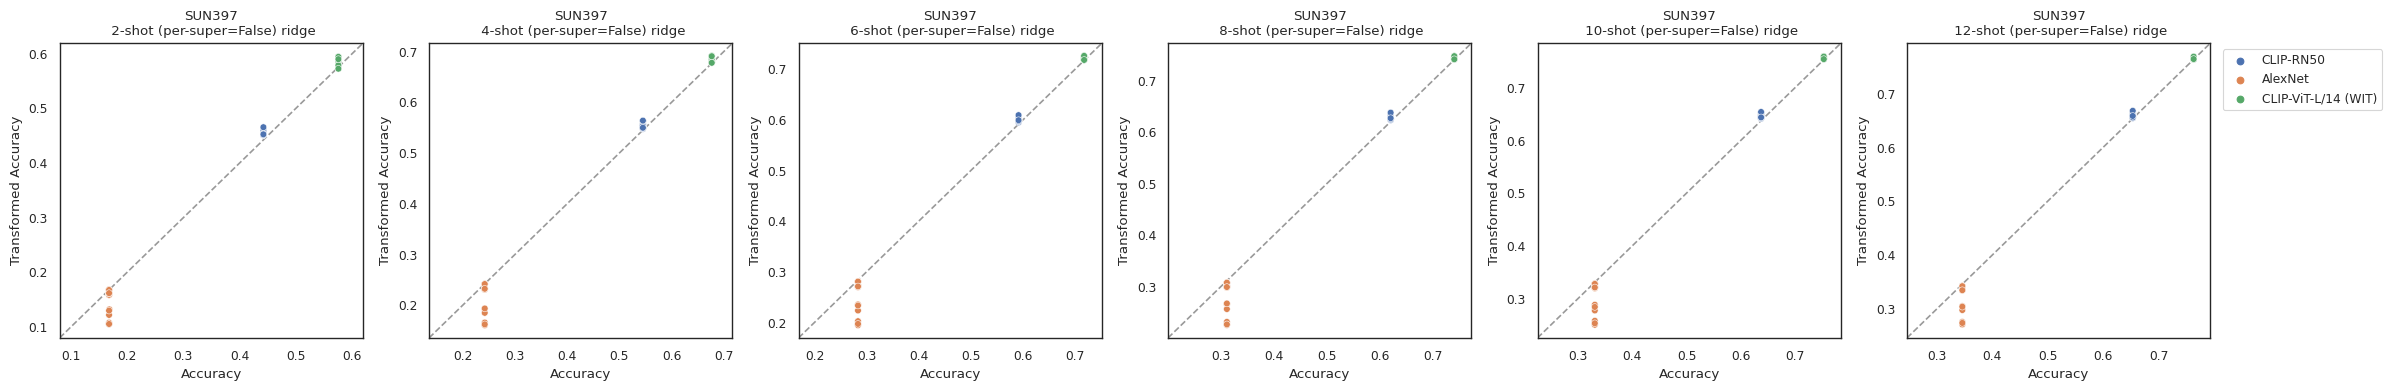

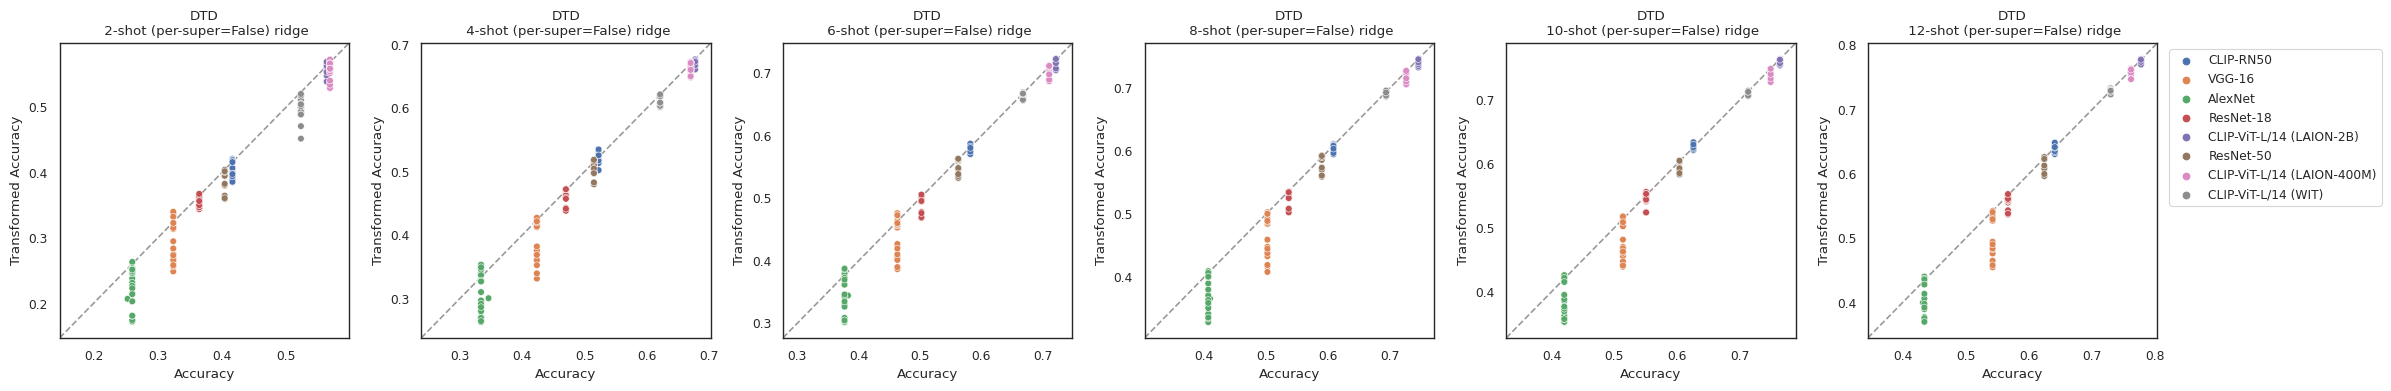

In [ ]:
for data, task in zip(datas_fs, tasks_fs):
    plot_fs(data, task)

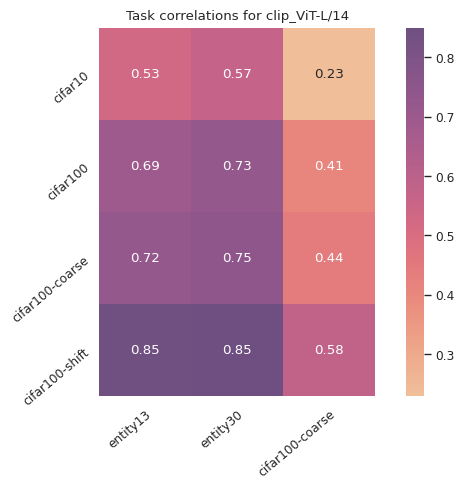

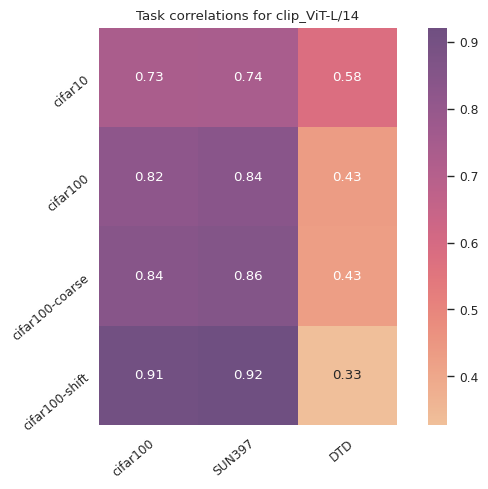

In [ ]:
plot_adfs_corr(datas_ad, datas_fs_c, sps=True, n_shots=4, models=["clip_ViT-L/14"])
plot_adfs_corr(datas_ad, datas_fs_f, sps=False, n_shots=4, models=["clip_ViT-L/14"])

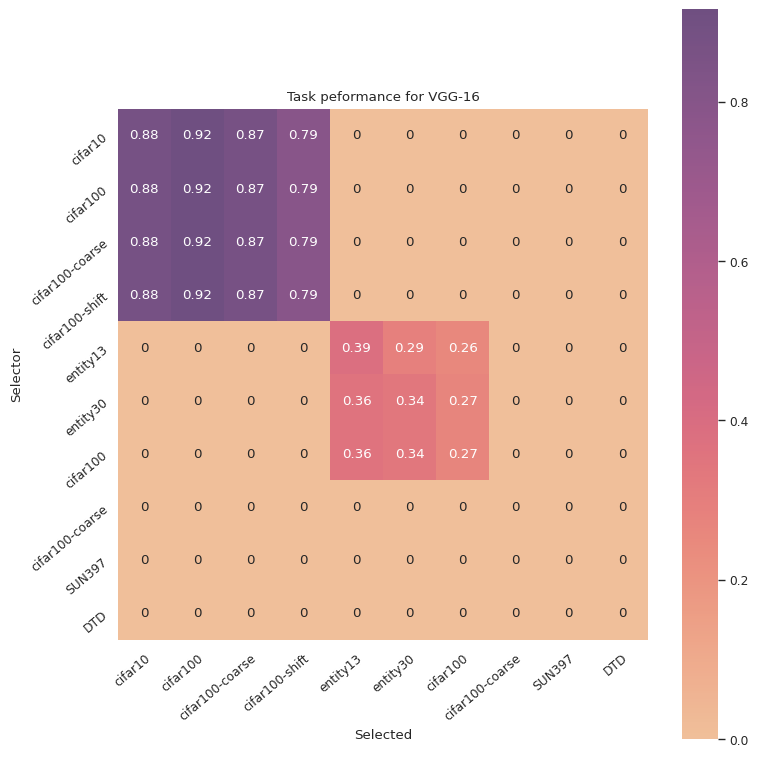

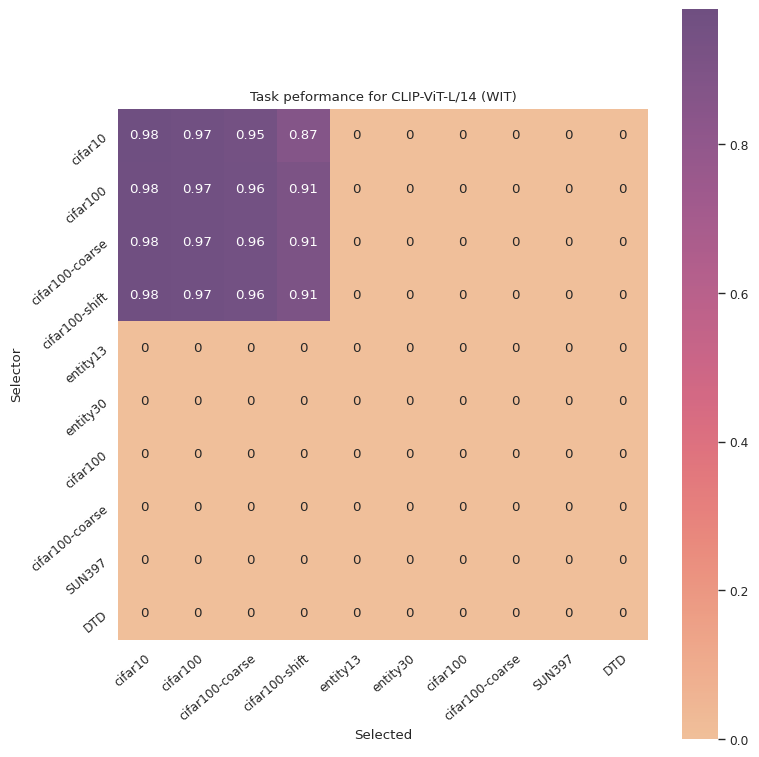

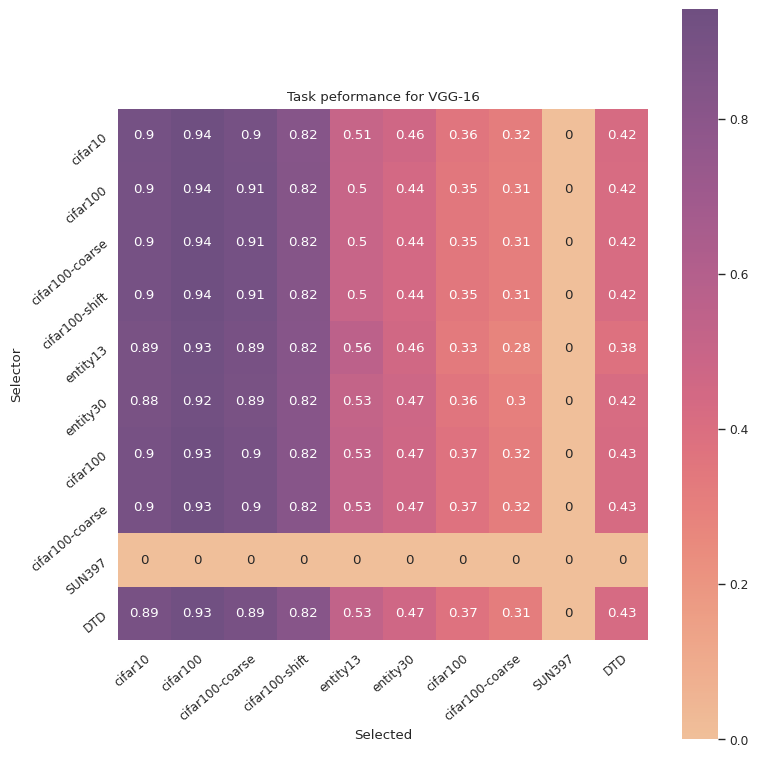

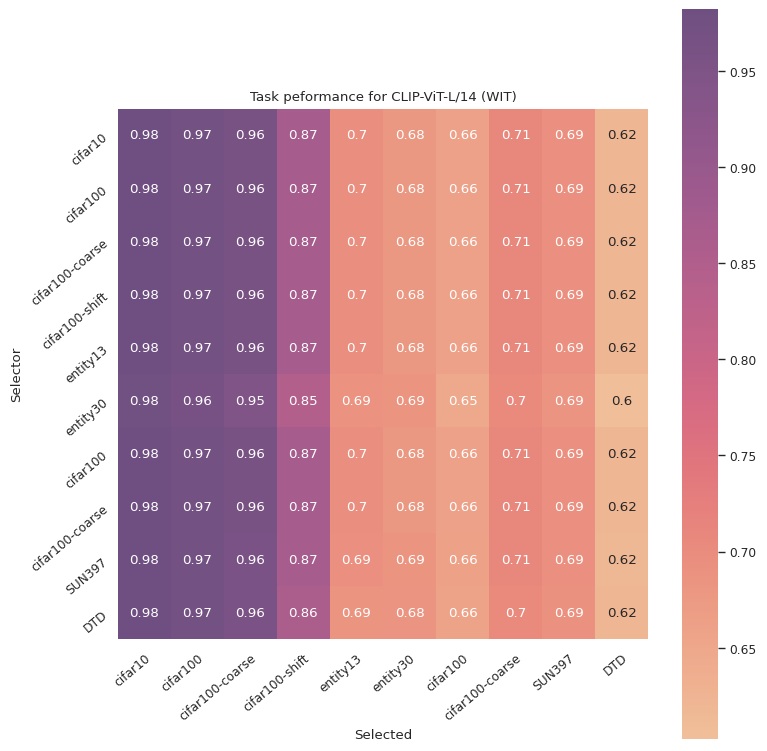

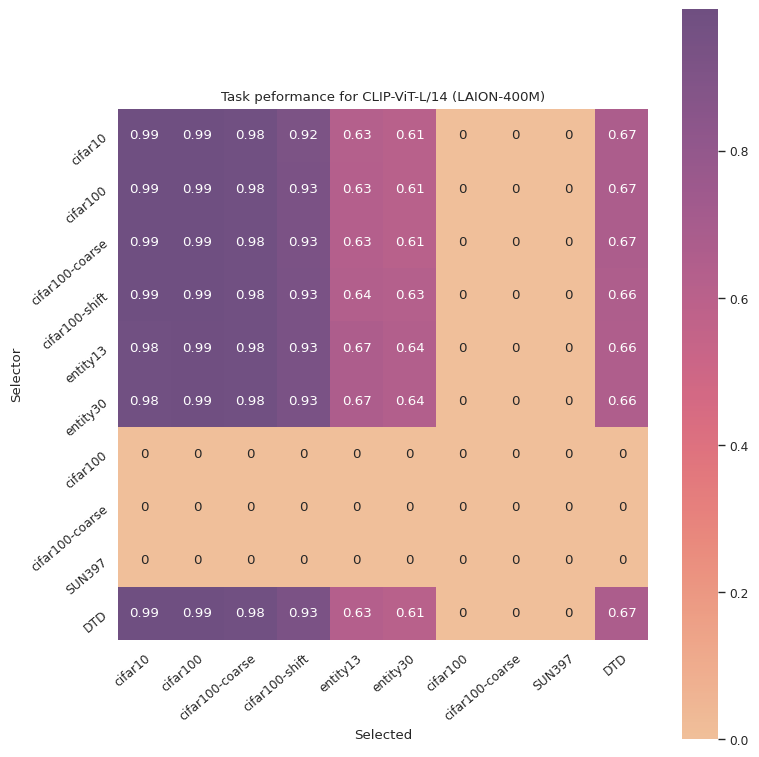

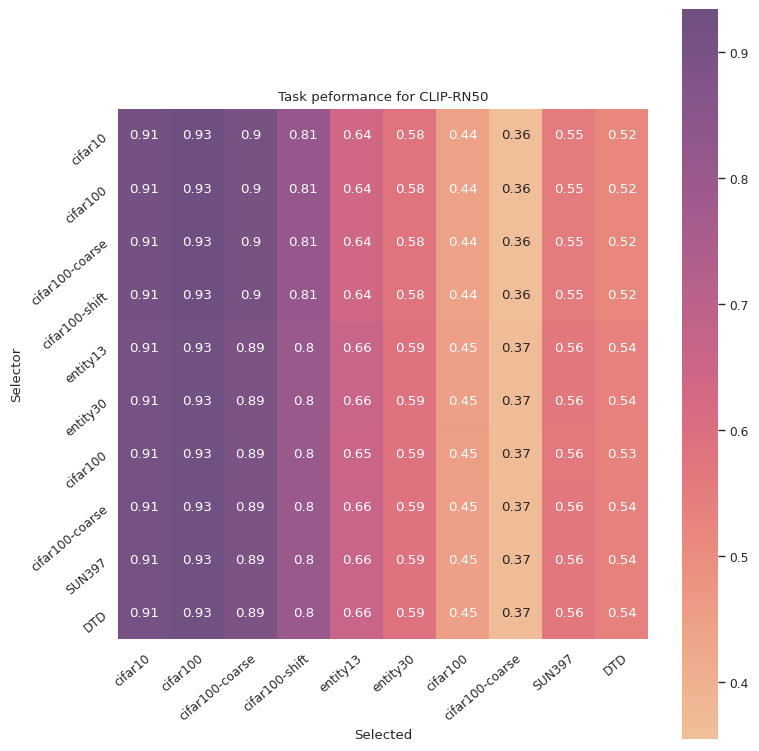

In [ ]:

task_selection_adfs(datas_global_ad, datas_global_fs_cf, sps=True, n_shots=2, models=["vgg16","clip_ViT-L/14"])
task_selection_adfs(datas_ad, datas_fs_cf, sps=None, n_shots=4, models=["vgg16","clip_ViT-L/14", "OpenCLIP_ViT-L-14_laion400m_e32", "clip_RN50"])

In [ ]:
# Comparison: optimal vs selected
datas_fs_cf_2 = [daf[daf.n_train==4] for daf in datas_fs_cf]

datas_fs_opt = pd.concat([select_by(daf, daf, "fs_accuracy_t") for daf in datas_fs_cf_2])
datas_fs_opt["optim_boost"] = 100 * (datas_fs_opt["fs_accuracy_t"] -  datas_fs_opt["fs_accuracy"])
datas_fs_opt["fs_accuracy"] = 100 * datas_fs_opt["fs_accuracy"]
datas_fs_opt = datas_fs_opt[["dataset", "model_pretty", "eta", "lmbda", "tau", "alpha", "fs_accuracy", "optim_boost"]]

datas_fs_sel = pd.concat([select_by(daf, datas_ad[-1], "ad_auc_t") for daf in datas_fs_cf_2])
datas_fs_sel["boost"] = 100 * (datas_fs_sel["fs_accuracy_t"] -  datas_fs_sel["fs_accuracy"])
datas_fs_sel["fs_accuracy"] = 100 * datas_fs_sel["fs_accuracy"]
datas_fs_sel = datas_fs_sel[["dataset", "model_pretty", "eta", "lmbda", "tau", "alpha", "fs_accuracy", "boost"]]

datas_fs_sel.merge(datas_fs_opt, on=["dataset", "model_pretty"], how='inner')
# Sometimes "optmal" is worse than the selected one -- why? -> there seem to be some data points w old seeds, changing the baseline

,dataset,model_pretty,eta_x,lmbda_x,tau_x,alpha_x,fs_accuracy_x,boost,eta_y,lmbda_y,tau_y,alpha_y,fs_accuracy_y,optim_boost
0,entity13,CLIP-ViT-L/14 (WIT),0.001,0.1,0.5,0.1,64.412308,5.276923e+00,0.001,0.1,0.5,0.1,64.412308,5.276923
1,entity13,CLIP-RN50,0.01,0.1,1.0,0.1,61.956923,2.036923e+00,0.001,0.1,0.5,0.25,61.956923,4.218462
2,entity13,VGG-16,0.01,10.0,0.5,0.25,48.338462,2.049231e+00,0.001,0.1,0.5,0.25,48.338462,7.209231
3,entity13,AlexNet,0.01,1.0,1.0,0.25,35.033846,1.692308e-01,0.001,1.0,0.5,0.1,35.033846,7.615385
4,entity13,CLIP-ViT-L/14 (LAION-2B),0.001,0.1,0.5,0.25,64.889231,2.680000e+00,0.001,0.1,1.0,0.1,64.889231,3.252308
5,entity13,CLIP-ViT-L/14 (LAION-400M),0.001,1.0,1.0,0.1,62.843077,1.418462e+00,0.001,0.1,1.0,0.1,62.843077,3.723077
6,entity30,CLIP-ViT-L/14 (WIT),0.001,0.1,0.5,0.1,63.576667,4.310000e+00,0.01,0.1,0.5,0.1,65.366667,3.286667
7,entity30,CLIP-RN50,0.01,0.1,1.0,0.1,56.676667,1.260000e+00,0.001,0.1,0.5,0.25,56.676667,2.006667
8,entity30,VGG-16,0.01,10.0,0.5,0.25,42.170000,2.150000e+00,0.001,1.0,1.0,0.1,42.170000,4.910000
9,entity30,AlexNet,0.01,1.0,1.0,0.25,24.783333,-4.900000e-01,0.001,10.0,1.0,0.1,24.783333,4.253333


## Anomaly Detection Global vs Glocal

In [ ]:
def plot_ad_glob(datas, datas_glob, tasks, models=None):
    n = len(datas)
    m = 1#len(datas_glob)
    models = models if models is not None else datas_fs[0].model.unique()

    fig, axs = plt.subplots(n,m,figsize=(4*m, 3*n))
    if n==1:
        axs = np.array([axs])
    if m==1:
        axs = np.array([[ax] for ax in axs])
        
    for i1, (data, task1) in enumerate(zip(datas, tasks)):
        i2=0
        data_glob=datas_glob[i1]
        task2=task1
        datac = data.copy()
        datac["glocal"]=True
        data_globc = data_glob.copy()
        data_globc["glocal"]=False
        for column in ['eta', 'lmbda', 'tau', 'contrastive_batch_size', 'alpha']:
                data_globc[column] = data_globc[column].astype(float)
        joint = pd.concat([datac,data_globc])
        
        plot = sns.boxplot(data=joint, 
                    y="ad_auc_t", 
                    x="model_pretty", 
                    hue="glocal", 
                    ax=axs[i1, i2],
                    palette="deep")

        dataset1 = datac["dataset"].unique()[0]
        dataset2 = data_globc["dataset"].unique()[0]        
        axs[i1, i2].set_xlabel("Model")
        plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.legend()        
    plt.tight_layout()
    plt.show()

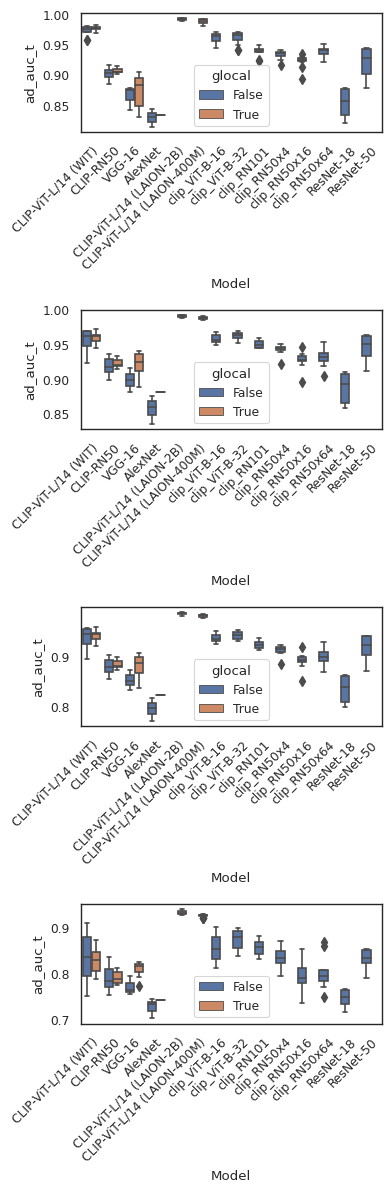

In [ ]:
plot_ad_glob(datas_ad, datas_global_ad, tasks_ad)

## Anomaly Detection Results

In [ ]:
datas_ad, tasks_ad = get_ad_data()
datas_global_ad, _ = get_ad_data(glocal=False)
ad_results = pd.read_csv(os.path.join(ROOT, f"ad_results_v1.csv"))
baselines = ad_results[(ad_results['transform'] == 'baseline')]
models = ad_results.model.unique()

In [ ]:
dataset_names = {'cifar10': 'CIFAR10 OVR', 
                 'cifar100': 'CIFAR100 OVR',
                 'cifar100-coarse': 'C100-Coarse OVR', 
                 'cifar100-shift': 'C100-Shift OVR',
                 'cifar10-rvo': 'CIFAR10 LOO',
                 'cifar100-rvo': 'CIFAR100 LOO',
                 'cifar100-coarse-rvo': 'C100-Coarse LOO', 
                 'cifar10vs100': 'C10 vs C100'}

model_mapping = {
    'alexnet': 'Alexnet',
    'vgg16': 'VGG-16',
    'resnet18': 'ResNet-18',
    'resnet50': 'ResNet-50',
    'clip_RN50': 'CLIP RN50',
    'clip_ViT-L/14': 'CLIP ViT-L/14',
    'OpenCLIP_ViT-L-14_laion400m_e32': 'OpenCLIP ViT-L/14 (Laion-400M)',
    'OpenCLIP_ViT-L-14_laion2b_s32b_b82k': 'OpenCLIP ViT-L/14 (Laion-2B)'
}

In [ ]:
def format(x):
  return round(x * 100, 2)

In [ ]:
results = []
def result_table_df(datasets):
  for model in model_mapping.keys():
    model_result = {
        'Model': model_mapping[model],
    }
    for task_data in datas_global_ad:
      task = task_data.dataset.unique()[0]
      if task not in datasets:
        continue
      model_results = task_data[task_data.model == model]
      if len(model_results) > 0:
        baseline = baselines[(baselines.dataset == task) & (baselines.model == model)]
        baseline = baseline.mean_auc.max()
        best_transformed = model_results[model_results['transform'] != 'baseline'].mean_auc.max()
        baseline = format(baseline)
        best_transformed = format(best_transformed)
        if baseline > best_transformed:
          baseline = '\textbf{' + str(baseline) + '}'
        else:
          best_transformed = '\textbf{' + str(best_transformed) + '}'
        model_result[task + '_before'] = baseline
        model_result[task + '_after'] = best_transformed
    results.append(model_result)
  df = pd.DataFrame(results)
  return df

In [ ]:
def generate_latex_table(results_df, datasets):
  first_line = ''
  second_line = 'Model & '
  for task in datasets:
    name = dataset_names[task]
    first_line += '\multicolumn{2}{c}{' + name + '} & '
    second_line += 'before & after & '
  print(first_line)
  print(second_line)
  print(results_df.to_latex(index=False, escape=False))

In [ ]:
datasets = ['cifar10', 'cifar100', 'cifar100-coarse', 'cifar100-shift']
results_df = result_table_df(datasets=datasets)
generate_latex_table(results_df, datasets)

In [ ]:
datasets = ['cifar10-rvo', 'cifar100-rvo', 'cifar100-coarse-rvo', 'cifar10vs100']
results_df = result_table_df(datasets=datasets)
generate_latex_table(results_df, datasets)